# ECE 417 Lecture 7: Image Upsampling and Downsampling
## Mark Hasegawa-Johnson, September 16, 2021
This file is distributed under a <a href="https://creativecommons.org/licenses/by/3.0/">CC-BY</a> license.  You may freely re-use or re-distribute the whole or any part.  If you re-distribute a non-trivial portion of it, give me credit.

## Outline of Today's lecture
* Decimation
* Downsampling
* Upsampling 
* Piece-wise constant interpolation
* Piece-wise linear interpolation
* Piece-wise spline interpolation
* Sinc interpolation

# Preliminaries
First let's load some libraries, and some data.

Text(0.5, 1.0, 'Image of a cat with resolution (240, 424, 3)')

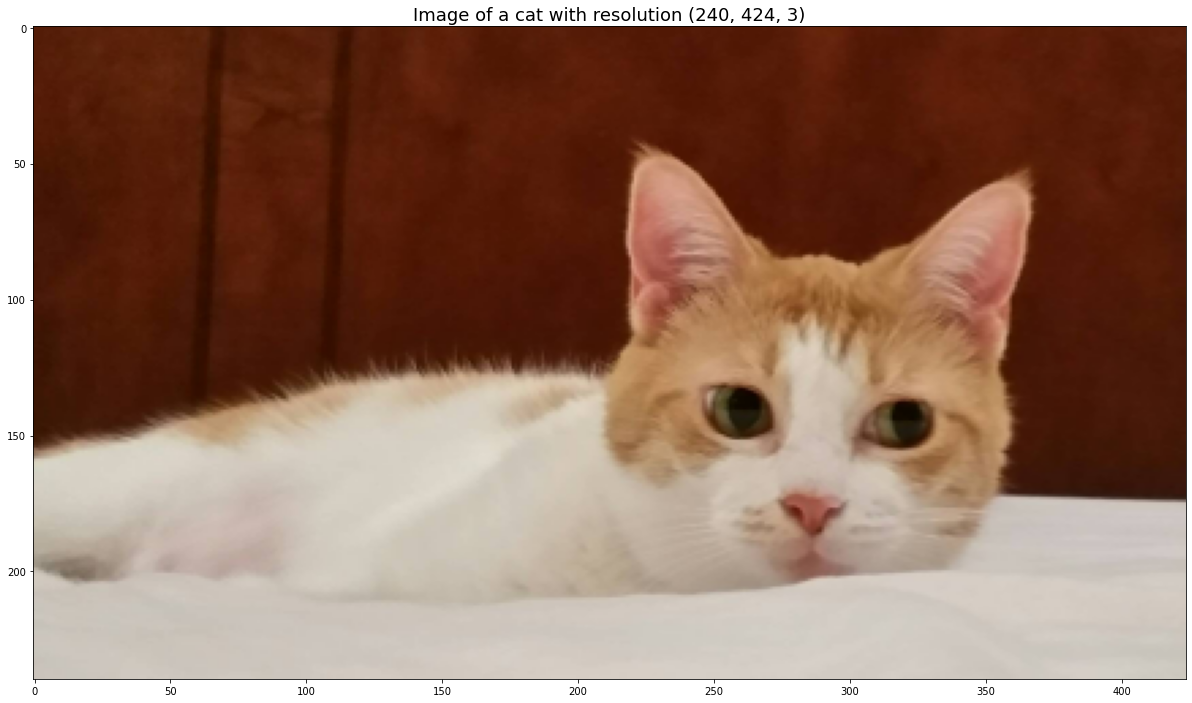

In [10]:
import imageio # for image i/o
import numpy as np  # general numeric operations and matrices
import io # for io.BytesIO, turns the data stream into a file-like object
import matplotlib.pyplot as plt # allows us to plot things
import urllib.request as request # downloads a file from the web
import math # for things like pi
%matplotlib inline
image_url = 'http://isle.illinois.edu/speech_web_lg/coursematerials/ece417/18fall/cat400.png'
cat400=imageio.imread(io.BytesIO(request.urlopen(image_url).read())).astype(float)
plt.figure(1,figsize=(int(424*0.05),int(240*0.05)))
plt.imshow(cat400.astype('uint8'))
plt.title('Image of a cat with resolution {}'.format(cat400.shape),fontsize=18)


# Image as a signal

Notice that, in this case, the size of the image is $(240,480,3)$, meaning that it has 240 rows, 480 columns, and 3 colors.  `imageio` creates a numpy array indexed in that order (rows, columns, colors); other packages index in other orders, so you have to be careful each time you use a new package.  In any case, we can index this image as 

$$x[m,n,k]$$

where we'll use

* $m$ to index the row,
* $n$ to index the column,
* $k$ to index the color plane (red, green, or blue).

# Decimation

Decimation just means we remove $D-1$ out of every $D$ samples, thus
$$y[m,n,k]=x[mD,nD,k]$$



(60, 106, 3)


Text(0.5, 1.0, 'Cat Decimated to 60x106x3')

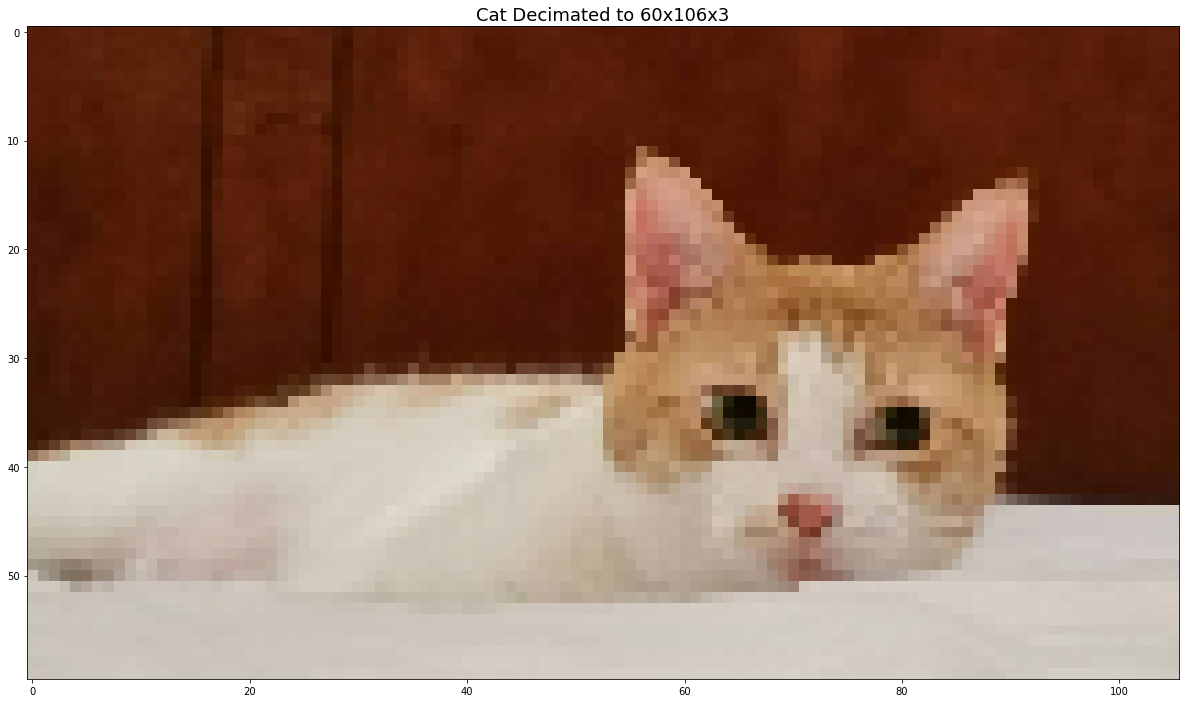

In [11]:
(M,N,K)=cat400.shape
cat100=cat400[::4,::4,:]
print(cat100.shape)
plt.figure(1,figsize=(int(424*0.05),int(240*0.05)))
plt.imshow(cat100.astype('uint8'))
plt.title('Cat Decimated to 60x106x3',fontsize=18)

Text(0.5, 1.0, 'Row 160 of fullsize image (blue), row 40 of decimated image (orange), color k=2')

<Figure size 432x288 with 0 Axes>

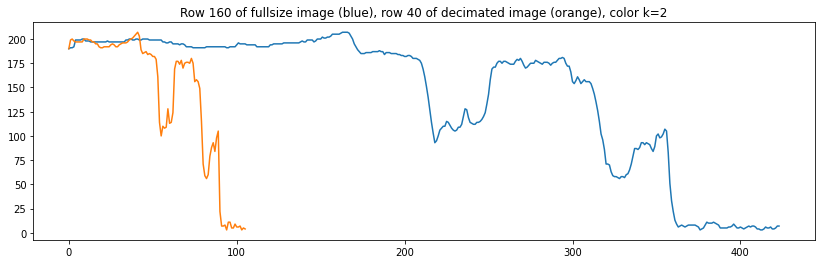

In [12]:
plt.figure()
t4=np.linspace(0,N-1,N,dtype='int16')
f1=plt.figure(figsize=(14,4))
plt.plot(t4,cat400[160,:,2],t4[:106],cat100[40,:,2])
plt.title('Row 160 of fullsize image (blue), row 40 of decimated image (orange), color k=2')



### Fourier transforms of the high-resolution and downsampled images

Remember that the multi-dimensional Fourier transform is
$$X(\omega_1,\omega_2,\omega_3)=\sum_{n_1}\sum_{n_2}\sum_{n_3}x[n_1,n_2,n_3]e^{-j(\omega_1n_1+\omega_2n_2+\omega_3n_3)}$$

Since this is a separable operation, we can learn a lot by just focusing on one dimension at a time.  For example, let's define the DTFT of a row to be:

$$X(m,\omega,k)=\sum_n x[m,n,k]e^{-j\omega n}$$
$$Y(m,\omega,k)=\sum_n y[m,n,k]e^{-j\omega n}$$

But what is the relationship between $Y(\omega)$ and $X(\omega)$?  Hint: it involves aliasing.

This is easiest to analyze in two steps.  First, multiply $x[n]$ by 
$$p[n]=\sum_{m=-\infty}^\infty \delta[n-mD]$$
in order to get the signal 
$$v[n]=p[n]x[n]$$



Text(0.5, 1.0, 'Cat Multiplied by Pulse Train')

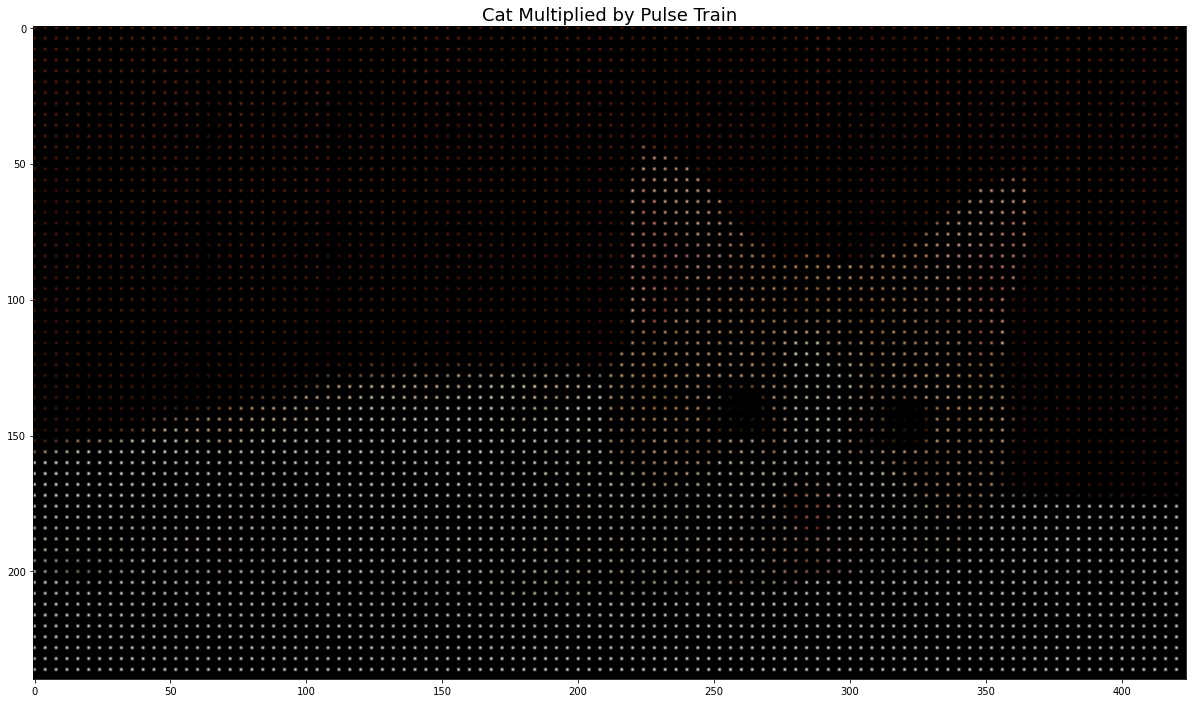

In [13]:
pulsetrain = np.zeros((M,N,K))
pulsetrain[::4,::4,:]=1
cat400_times_pulsetrain = cat400 * pulsetrain
plt.figure(1,figsize=(int(424*0.05),int(240*0.05)))
plt.imshow(cat400_times_pulsetrain.astype('uint8'))
plt.title('Cat Multiplied by Pulse Train',fontsize=18)

#### What's the Fourier transform of a pulse train?

The Fourier transform of a pulse train is a pulse train:

$$p[n]=\sum_{m=-\infty}^\infty \delta[n-mD]$$
which has a transform of 
$$P(\omega)=\frac{2\pi}{D}\sum_{k=0}^{D-1} \delta\left(\omega-\frac{2\pi k}{D}\right)$$


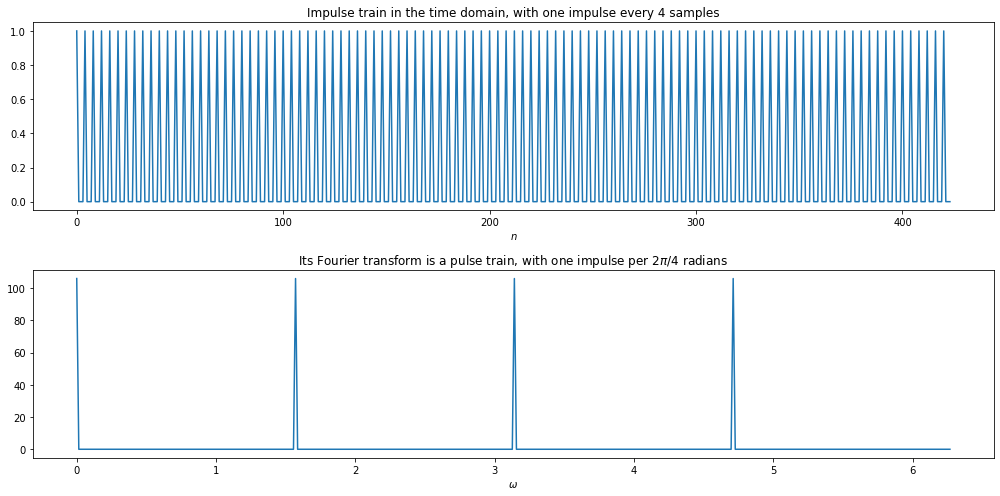

In [20]:
pulsetrain_transformed = np.fft.fft(pulsetrain[0,:,0])
n = np.arange(N)
omega = np.linspace(0,2*np.pi,N,endpoint=False)
fig, ax = plt.subplots(2,1, figsize=(14,7))
ax[0].plot(n,pulsetrain[0,:,0])
ax[0].set_title('Impulse train in the time domain, with one impulse every 4 samples')
ax[0].set_xlabel('$n$')
ax[1].plot(omega,np.abs(pulsetrain_transformed))
ax[1].set_title('Its Fourier transform is a pulse train, with one impulse per $2\pi/4$ radians')
ax[1].set_xlabel('$\omega$')
fig.tight_layout()

### Multiplying in the time domain is convolving in the frequency domain

Remember that $v[n]=p[n]x[n]$.  Remember, also, that multiplying two signals in the time domain is the same as convolving them in the frequency domain:

$$v[n]=x[n]p[n]  \Leftrightarrow V(\omega)=\frac{1}{2\pi} P(\omega)\ast X(\omega)$$

Since convolving any signal with an impulse is the same as shifting the signal, we get that

$$P(\omega)=\frac{2\pi}{D}\sum_{k=0}^{D-1} \delta\left(\omega-\frac{2\pi k}{D}\right)$$

implies that

$$V(\omega) = \frac{1}{D} \sum_{k=0}^{D-1}X\left(\omega-\frac{2\pi k}{D}\right)$$

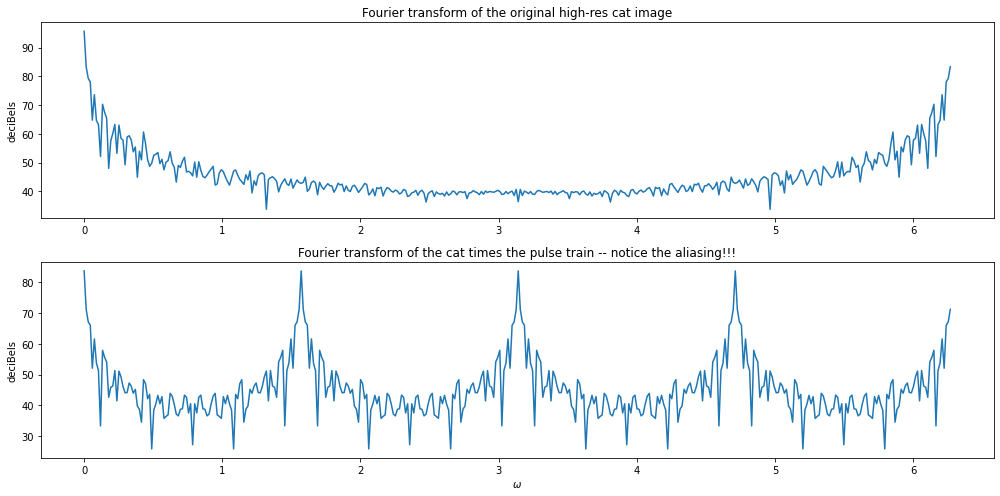

In [21]:
cat400_transformed = np.fft.fft(cat400[160,:,2])
cat400_times_pulsetrain_transformed = np.fft.fft(cat400_times_pulsetrain[160,:,2])
fig, ax = plt.subplots(2,1, figsize=(14,7))
ax[0].plot(omega,20*np.log10(np.abs(cat400_transformed)))
ax[0].set_title('Fourier transform of the original high-res cat image')
ax[0].set_ylabel('deciBels')
ax[1].plot(omega,20*np.log10(np.abs(cat400_times_pulsetrain_transformed)))
ax[1].set_title('Fourier transform of the cat times the pulse train -- notice the aliasing!!!')
ax[1].set_xlabel('$\omega$')
ax[1].set_ylabel('deciBels')
fig.tight_layout()

Notice that $v[n]$ has all of the same samples as the downsampled image $y[n]$ -- they're just spread out, with 3 zeros between each nonzero sample.  Getting rid of the zeros doesn't change the spectrum, so we can compute it as follows:

$$y[n] = v[nD]$$
$$Y(\omega)=\sum_n y[n]e^{-j\omega n}$$
$$=\sum_m v[m=nD]e^{-j\omega m/D}$$
$$=V\left(\frac{\omega}{D}\right)$$

In other words, $Y(\omega)=V(\omega/D)$, which basically means that we just relabel the frequency axis -- anything that happens at $\omega=2\pi/D$ on the frequency axis for $V(\omega)$ happens at $\omega=2\pi$ on the frequency axis for $Y(\omega)$.  In particular, both $V(\omega)$ and $Y(\omega)$ have the same aliasing:

$$Y(\omega)= \left(\frac{1}{D}\right)\sum_{d=0}^{D-1} X\left(\frac{\omega-2\pi d}{D}\right)$$

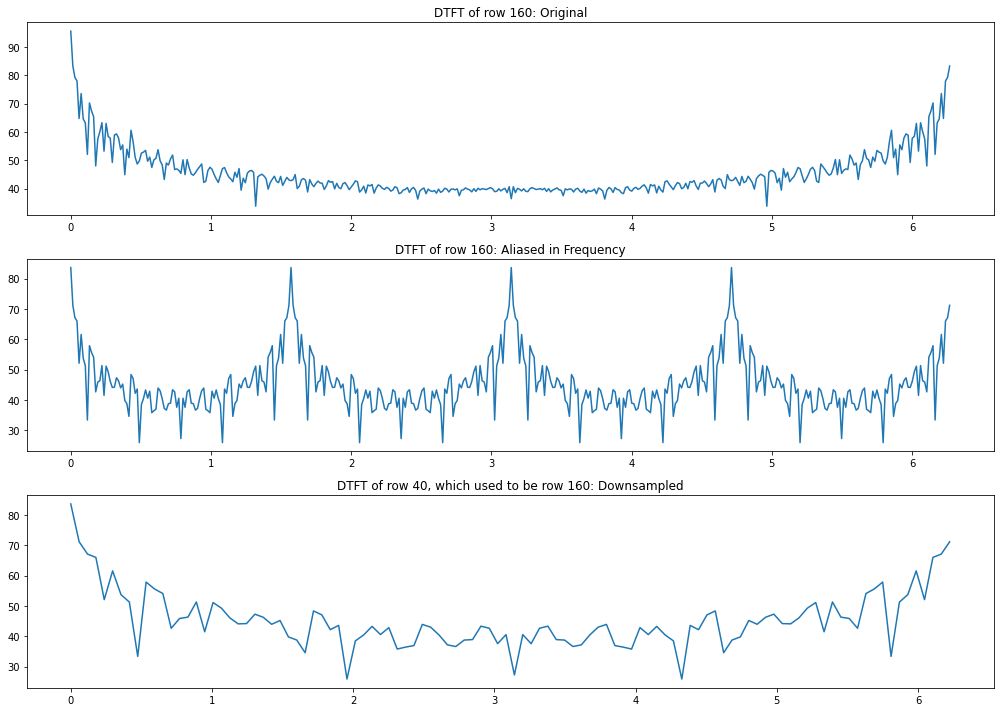

In [16]:
cat100_transformed = np.fft.fft(cat100[40,0:106,2])

fig = plt.figure(1,figsize=(14,10))
plt.subplot(311)
plt.plot(omega,20*np.log10(abs(cat400_transformed)))
plt.title('DTFT of row 160: Original')
plt.subplot(312)
plt.plot(omega,20*np.log10(abs(cat400_times_pulsetrain_transformed)))
plt.title('DTFT of row 160: Aliased in Frequency')
plt.subplot(313)
plt.plot(omega[::4],20*np.log10(abs(cat100_transformed)))
plt.title('DTFT of row 40, which used to be row 160: Downsampled')
fig.tight_layout()

# Downsampling
We can avoid aliasing by lowpass filtering the signal prior to decimation.

The term `downsampling`, in general, just means "reducing the sampling rate."  The right way to downsample is to lopass filter, and then to decimate.

An ideal lowpass filter with cutoff frequency $\omega_c$ is given by
$$h[n]=\frac{\omega_c}{\pi}\mbox{sinc}(\omega_c n)=\frac{\sin(\omega_c n)}{\pi n}$$
When we create a lowpass filter by hand, we have to be careful with the $n=0$ sample:
$$h[0]=\frac{\omega_c}{\pi}$$
In order to avoid aliasing, we need
$$\omega_c=\frac{\pi}{D}$$
We can approximate an ideal lowpass filter by creating a reasonably long, rectangular-windowed FIR filter
(Hamming window would be better).  Then we can lowpass filter by convolving each row and each column:
    $$x_{lpf}[n]=h[n]\ast x[n]$$
    $$y_{lpf}[n] = x_{lpf}[nD]$$

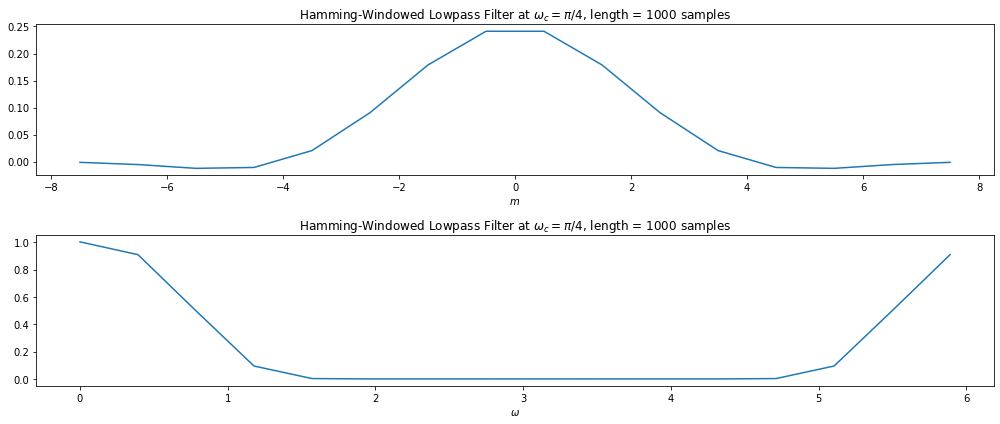

In [48]:
n16 = np.arange(-7.5,8.5)
omega16 = np.linspace(0,2*np.pi,16,endpoint=False)
lpf = 0.25 * np.hamming(16) * np.sin(np.pi*n16/4) / (np.pi*n16/4)
lpf16_transformed = np.fft.fft(lpf)
fig=plt.figure(1,figsize=(14,6))
plt.subplot(211)
plt.plot(n16,lpf)
plt.title('Hamming-Windowed Lowpass Filter at $\omega_c=\pi/4$, length = 1000 samples')
plt.xlabel('$m$')
plt.subplot(212)
plt.plot(omega16,np.abs(lpf16_transformed))
plt.title('Hamming-Windowed Lowpass Filter at $\omega_c=\pi/4$, length = 1000 samples')
plt.xlabel('$\omega$')
fig.tight_layout()

### Separable Filter

The np.convolve2d function implements convolution in two dimensions, but it's very slow to convolve in 2D (complexity is O($M^2N^2$)).  

A much faster method is to first convolve each column (complexity: O($N^2$)), then convolve each row (complexity: O($M^2$)), total complexity is only O($M^2+N^2$).  This is called "separable filtering".

Here, we use mode='nearest' in order to repeat the outermost edge outward as padding for the convolution.

Text(0.5, 1.0, 'Cat that has been convolved with an LPF')

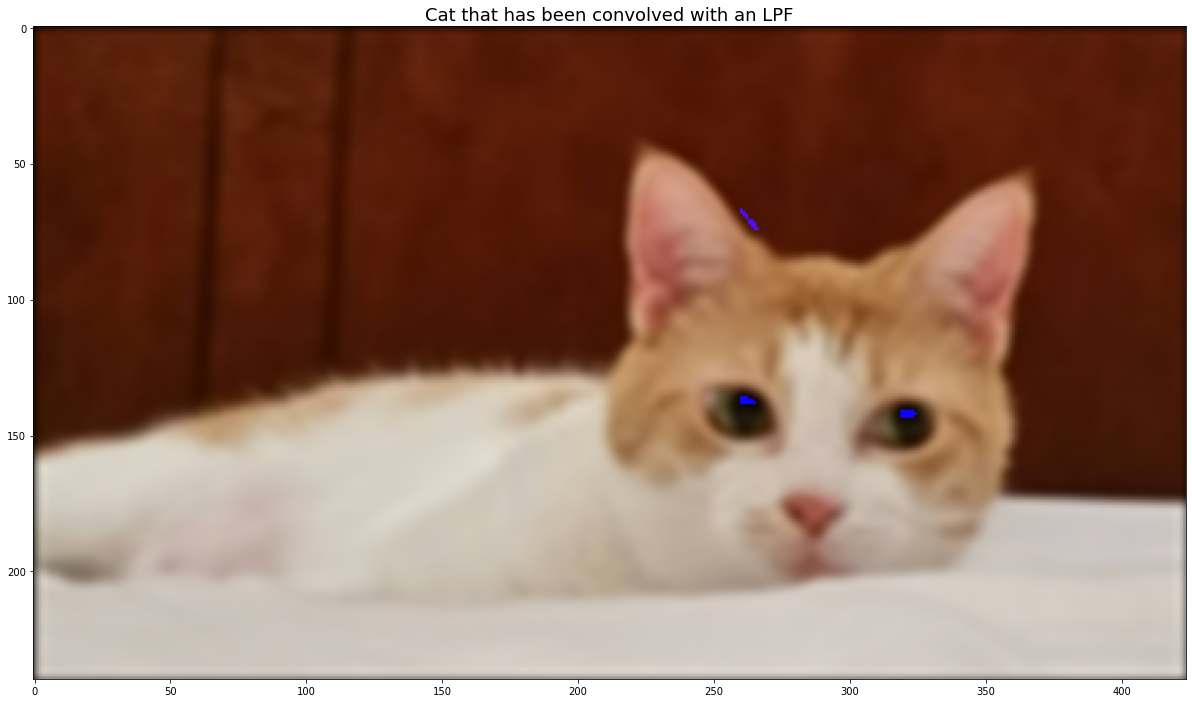

In [49]:
tmp = np.zeros((M,N,K))
cat400_lowpassfiltered = np.zeros((M,N,K))
for k in range(0,K):
    for m in range(0,M):
        tmp[m,:,k] = np.convolve(lpf, cat400[m,:,k], mode='same')
    for n in range(0,N):
        cat400_lowpassfiltered[:,n,k] = np.convolve(lpf, tmp[:,n,k], mode='same')
plt.figure(1,figsize=(int(424*0.05),int(240*0.05)))
plt.imshow(cat400_lowpassfiltered.astype('uint8'))
plt.title('Cat that has been convolved with an LPF',fontsize=18)

Now let's take its Fourier transform, to make sure that it has been lowpass filtered.

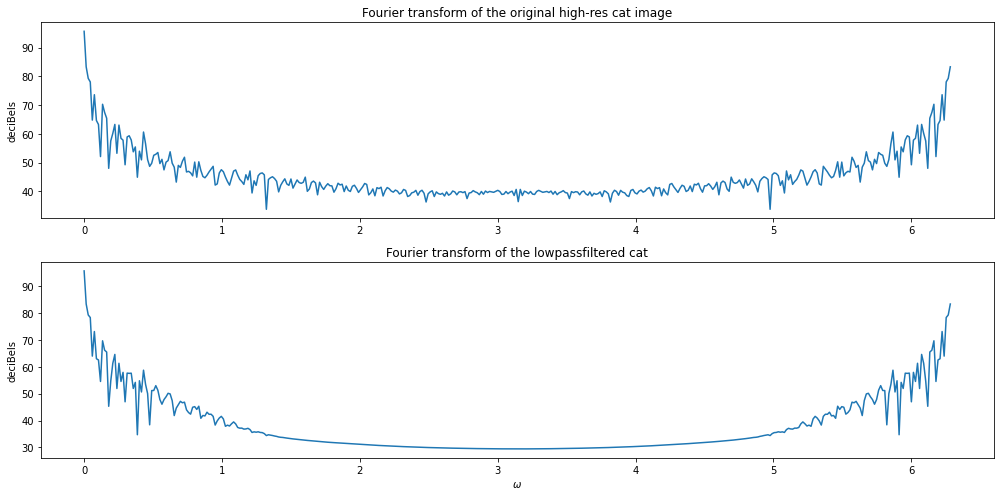

In [50]:
cat400_transformed = np.fft.fft(cat400[160,:,2])
cat400_lowpassfiltered_transformed = np.fft.fft(cat400_lowpassfiltered[160,:,2])
fig, ax = plt.subplots(2,1, figsize=(14,7))
ax[0].plot(omega,20*np.log10(np.abs(cat400_transformed)))
ax[0].set_title('Fourier transform of the original high-res cat image')
ax[0].set_ylabel('deciBels')
ax[1].plot(omega,20*np.log10(np.abs(cat400_lowpassfiltered_transformed)))
ax[1].set_title('Fourier transform of the lowpassfiltered cat')
ax[1].set_xlabel('$\omega$')
ax[1].set_ylabel('deciBels')
fig.tight_layout()

## Downsampling = Filtering followed by decimation
Now let's decimation the filtered image.  This should give a spectrum with much less aliasing.

Text(0.5, 1.0, 'Decimated cat: lowpass filtered, then downsampled')

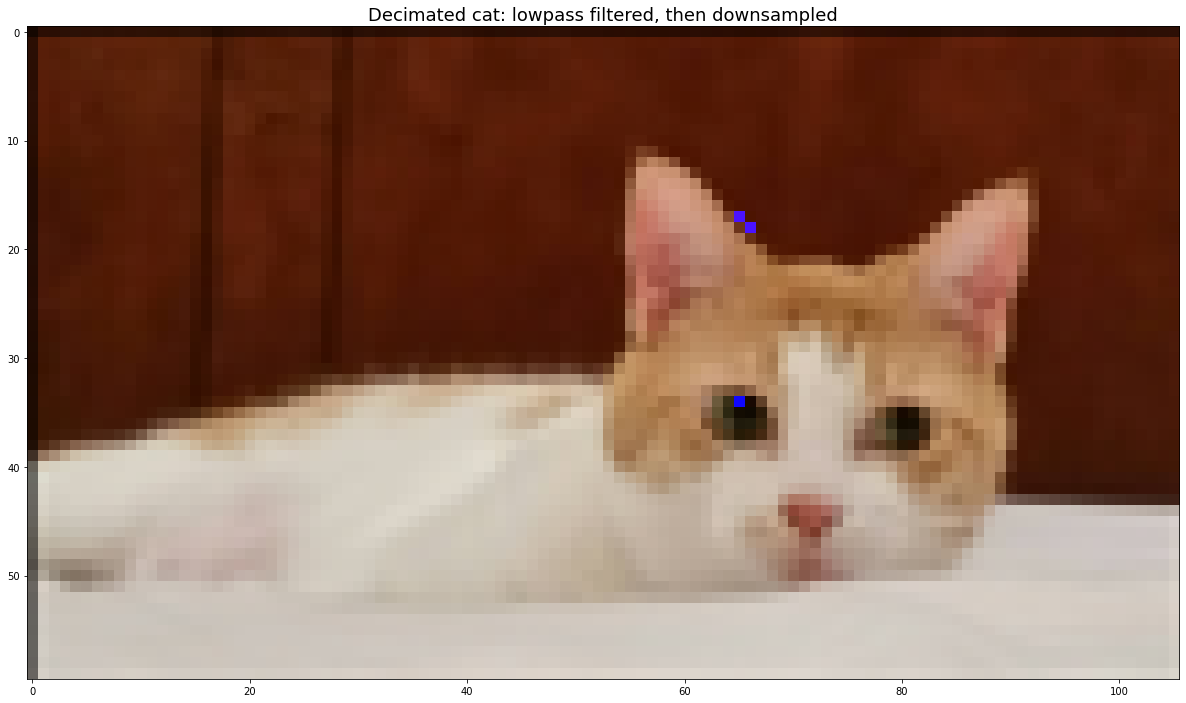

In [51]:
catf100 = cat400_lowpassfiltered[::4,::4,:]
plt.figure(1,figsize=(int(424*0.05),int(240*0.05)))
plt.imshow(catf100.astype('uint8'))
plt.title('Decimated cat: lowpass filtered, then downsampled',fontsize=18)

Let's compare the Fourier transforms of the cat that's just been downsampled, versus the one that's been lowpass filtered before downsampling, versus the Fourier transform of the original high-resolution cat image.

Text(0.5, 1.0, 'Spectrum of original (r), decimated (g), downsampled (b)')

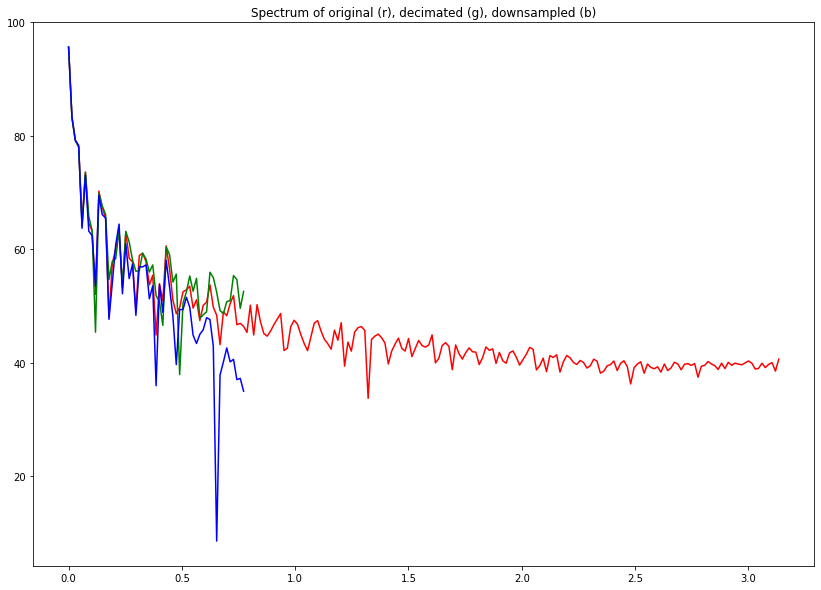

In [52]:
cat400db = 20*np.log10(np.abs(np.fft.fft(cat400[160,:,2])))
cat100db = 20*np.log10(4*np.abs(np.fft.fft(cat100[40,:,2])))
catf100db = 20*np.log10(4*np.abs(np.fft.fft(catf100[40,:,2])))
omega = np.linspace(0,2*np.pi,N)

fig, ax = plt.subplots(1,1,figsize=(14,10))
ax.plot(omega[:212],cat400db[:212],'r-',omega[:53],cat100db[:53],'g-',omega[:53],catf100db[:53],'b-')
ax.set_title('Spectrum of original (r), decimated (g), downsampled (b)')


# Upsampling

Upsampling is the process of creating a larger image, from a smaller image, by just inserting zeros:
$$z[m,n,k] = \left\{\begin{array}{ll}
y[m/D,n/D,k] & m/D,~n/D~\mbox{are integers}\\
0 & \mbox{otherwise}
\end{array}\right.$$

Notice: $z[n]$ is exactly the same as the signal $v[n]$ that we saw before!! So it has aliasing.

Again, the problem is aliasing:
$$Z(\omega) = V(\omega) = Y(D\omega)$$

This time, though, the aliasing is much more visible in the image.  In fact, the image is mostly black dots, with a few spots of color (one per $D\times D$ square).


Text(0.5, 1.0, 'Cat that has been upsampled without interpolation')

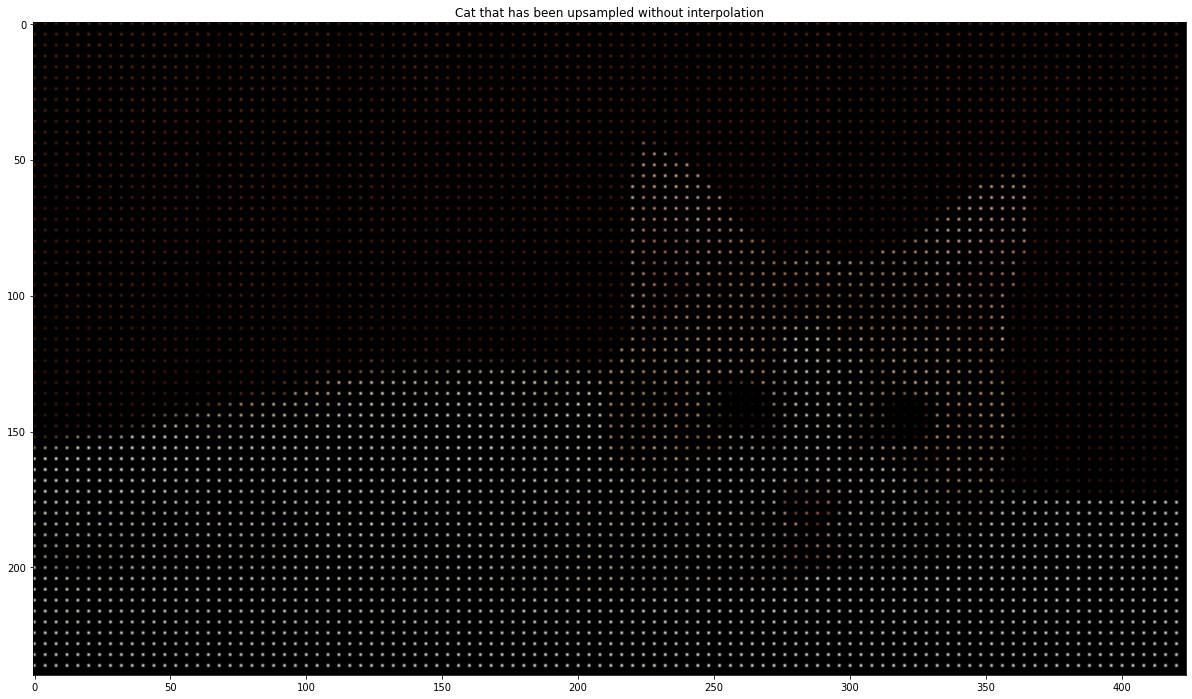

In [53]:
cat_upsampled = np.zeros(cat400.shape,dtype=cat400.dtype)
for m in range(0,60):
    for n in range(0,106):
        for k in range(0,K):
            cat_upsampled[4*m,4*n,k]=cat100[m,n,k]
plt.figure(1,figsize=(int(424*0.05),int(240*0.05)))
plt.imshow(cat_upsampled.astype('uint8'))
plt.title('Cat that has been upsampled without interpolation')

#  Piece-wise constant interpolation

The solution is obvious: rather than just filling zeros between the upsampled samples, we need to fill in some meaningful value.
The first solution to consider is piece-wise constant interpolation, sometimes called zero-order hold (ZOH).

$$z[m,n,k]=y[\mbox{int}(m/D),\mbox{int}(n/D),k]$$

This results in some aliasing, but not as bad as the upsampled cat.

Text(0.5, 1.0, 'Cat interpolated using PWC interpolation')

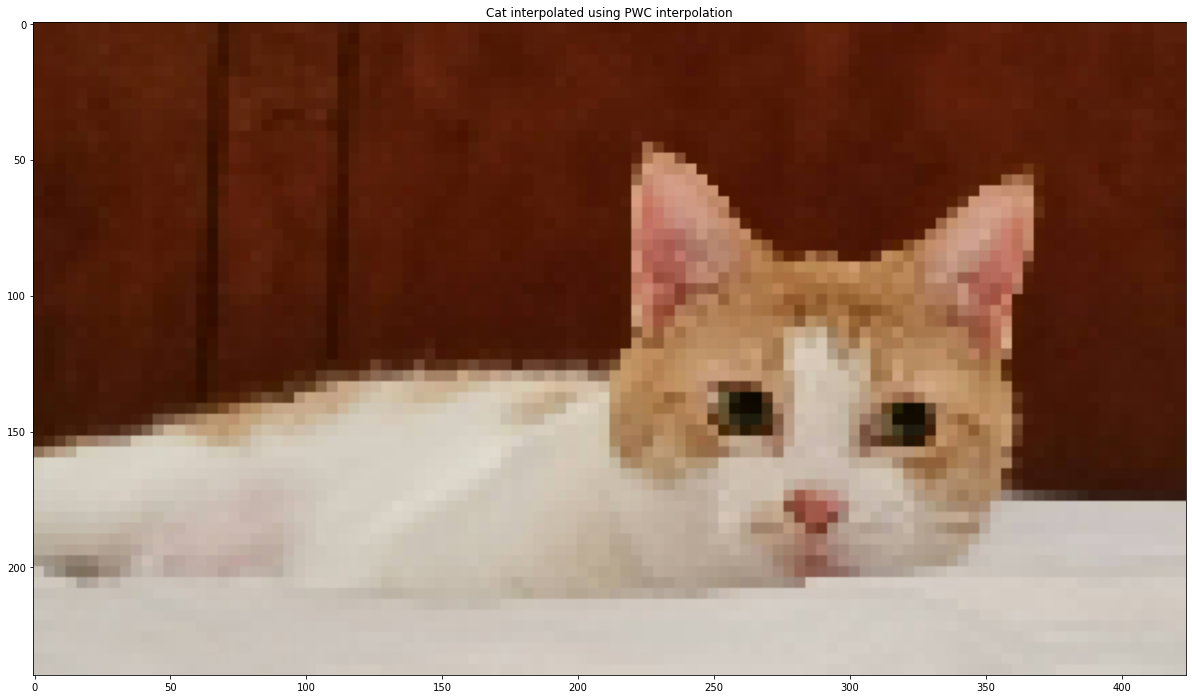

In [54]:
cat_pwc_double = np.zeros(cat400.shape,dtype=cat400.dtype)
for m in range(0,240):
    for n in range(0,424):
        for k in range(0,K):
            cat_pwc_double[m,n,k]=cat100[int(m/4),int(n/4),k]
cat_pwc = np.ndarray.astype(np.maximum(0,np.minimum(255,cat_pwc_double)),dtype='uint8')
plt.figure(1,figsize=(int(424*0.05),int(240*0.05)))
plt.imshow(cat_pwc)
plt.title('Cat interpolated using PWC interpolation')

# Piece-wise linear (bilinear) interpolation

Piece-wise linear interpolation, in two dimensions at the same time, is called bilinear interpolation.

We can accomplish it by **literally** doing a piece-wise linear interpolation of the signal, as in the following code:

In [60]:
tmp = np.zeros((M//4,N,K))
cat_pwl = np.zeros((M,N,K))
for k in range(3):
    for m in range(M/4):
        for n in range(0,N,4):
            fp = [ cat100[m,n//4,k], cat100[m,n//4+1,k] ]
            tmp[m,n:n+4,k]=np.interp([0,1,2,3],[0,4], fp)
    for n in range(N):
        for m in range(0,M,4):
            fp = [ tmp[m,n,k], tmp[m+1,n,k] ]
            cat_pwl[m:m+4,n,k] = np.interp([0,1,2,3],[0,4], fp)

plt.figure(1,figsize=(int(424*0.05),int(240*0.05)))
plt.imshow(cat_pwl.astype('uint8'))
plt.title('Cat upsampled using piece-wise linear interpolation')

TypeError: 'float' object cannot be interpreted as an integer

Notice that piece-wise-linear interpolation is just like upsampling the cat, and then convolving with the piece-wise linear interpolation filter:

$$h_{PWL}[n] = \left\{\begin{array}{ll}
\frac{D-|n|}{D} & -D\le n\le D\\
0 & \mbox{otherwise}\end{array}\right.
$$

Similarly, piece-wise constant interpolation is just like upsampling the cat, and then convolving with the piece-wise constant interpolation filter:

$$h_{PWC}[n] = \left\{\begin{array}{ll} 1 & 0\le n<D\\
0 & \mbox{otherwise}\end{array}\right.$$

Text(0.5, 1.0, 'PWL Interpolation is like convolving with the PWL interpolator')

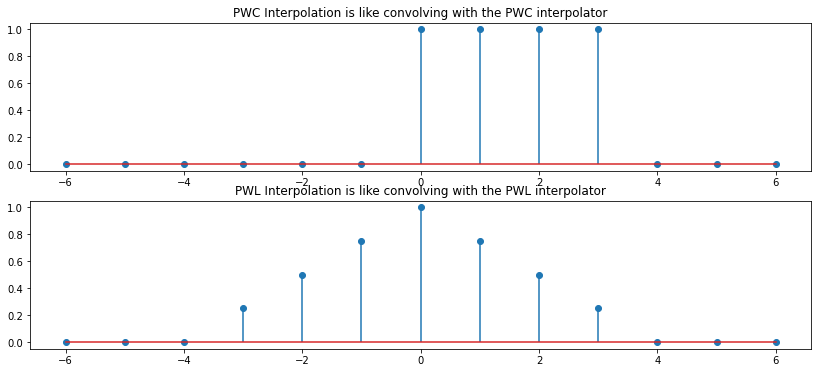

In [56]:
zero_sample = 6
n_axis = np.linspace(-zero_sample,zero_sample, 2*zero_sample+1, dtype='int16')
h_pwc = np.zeros(13)
h_pwl = np.zeros(13)
for n in range(0,4):
    h_pwc[zero_sample+n]=1
    h_pwl[zero_sample+n]=0.25*(4-n)
    h_pwl[zero_sample-n]=0.25*(4-n)
plt.figure(1,figsize=(14,6))
plt.subplot(211)
plt.stem(n_axis,h_pwc)
plt.title('PWC Interpolation is like convolving with the PWC interpolator')
plt.subplot(212)
plt.stem(n_axis,h_pwl)
plt.title('PWL Interpolation is like convolving with the PWL interpolator')

Just to prove it, let's recompute the bilinear-interpolated cat using the triangle filter above, and show that it's the same image.

Text(0.5, 1.0, 'Cat upsampled using a triangle interpolation kernel')

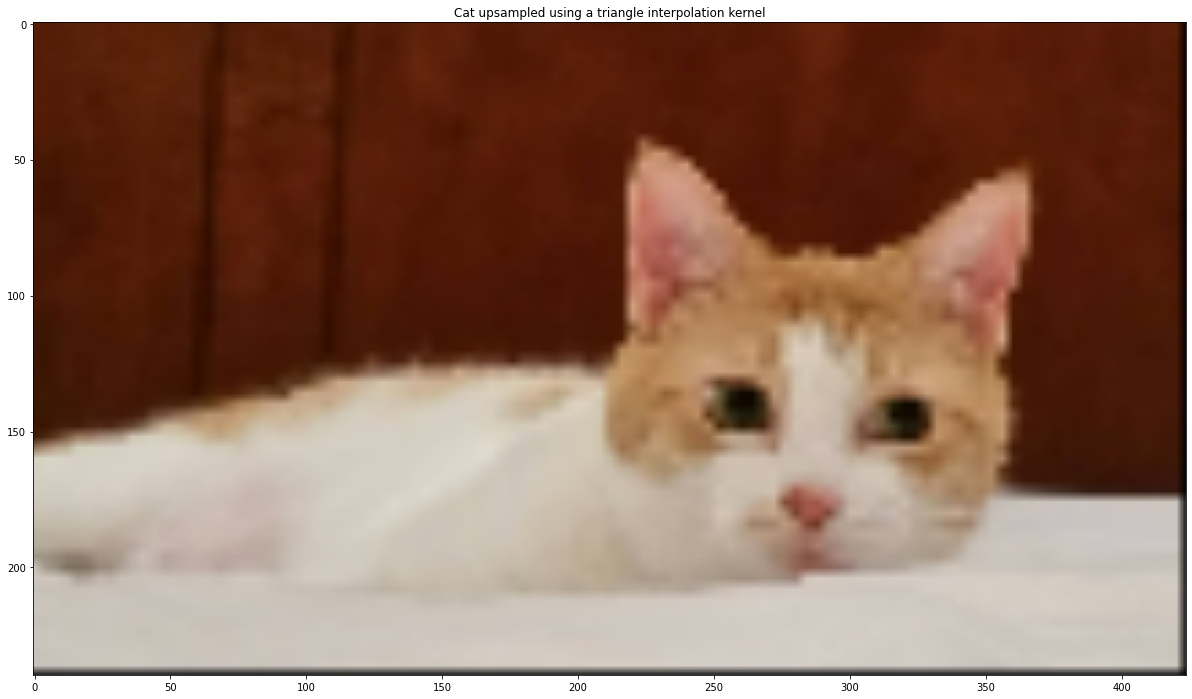

In [57]:
tmp = np.zeros((M,N,K))
cat_triangle = np.zeros((M,N,K))
for k in range(3):
    for m in range(M):
        tmp[m,:,k] = np.convolve(cat_upsampled[m,:,k],h_pwl,mode='same')
    for n in range(N):
        cat_triangle[:,n,k] = np.convolve(tmp[:,n,k], h_pwl, mode='same')
plt.figure(1,figsize=(int(424*0.05),int(240*0.05)))
plt.imshow(cat_triangle.astype('uint8'))
plt.title('Cat upsampled using a triangle interpolation kernel')

# Sinc Interpolation

PWC interpolation suffers from obvious blocky artifacts.  PWL interpolation smooths away most of those, but not all.
We can get rid of all of them, and get the lowpass-filtered cat back again exactly, by filtering the upsampled cat
using an ideal sinc function.

$$z[n]=D^2  h_{LPF}[n]\ast y[n]$$

Multiplying by a factor of $D^2$ is necessary because we're trying to construct $D^2$ output samples from every one input sample. 

Text(0.5, 1.0, 'Cat upsampled using sinc interpolation')

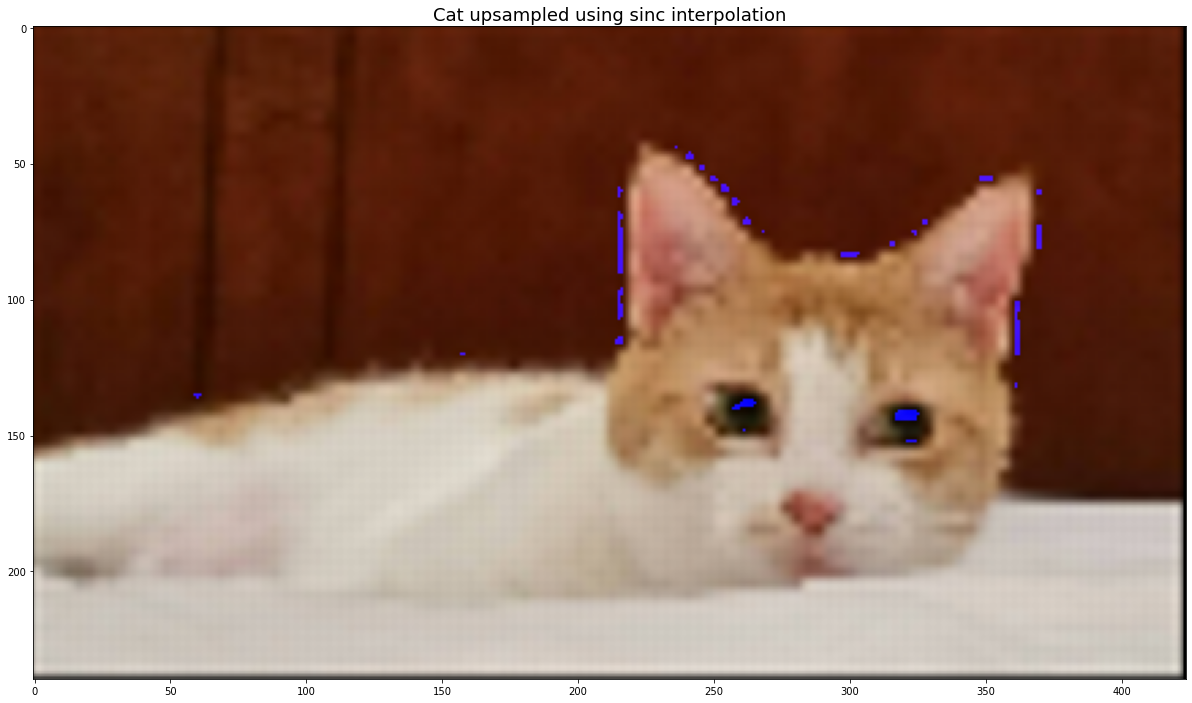

In [58]:
cat_si=np.zeros((240,424,3),dtype='double')
tmp=np.zeros((240,424,3),dtype='double')
for k in range(0,K):
    for m in range(0,M):
        tmp[m,:,k]=4*np.convolve(cat_upsampled[m,:,k],lpf,mode='same')
    for n in range(0,423):
        cat_si[:,n,k]=4*np.convolve(tmp[:,n,k],lpf,mode='same')
plt.figure(1,figsize=(int(424*0.05),int(240*0.05)))
plt.imshow(cat_si.astype('uint8'))
plt.title('Cat upsampled using sinc interpolation',fontsize=18)

# Summary of Visible Artifacts
* PWC: blocky artifacts
* PWL (Bilinear): some blocky artifacts because it interpolates within blocks, but the artifacts are a lot less than PWC interpolation.  Often, this is the best option.
* Sinc: ringing artifacts, that occur at sharp boundaries between two colors, and at the edge of the image, depending on how you handle edges.


